<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q d2l

     |████████████████████████████████| 82 kB 708 kB/s 
     |████████████████████████████████| 61 kB 8.0 MB/s 
     |████████████████████████████████| 11.2 MB 27.4 MB/s 
     |████████████████████████████████| 9.9 MB 32.5 MB/s 
     |████████████████████████████████| 15.7 MB 49.8 MB/s 
     |████████████████████████████████| 930 kB 48.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


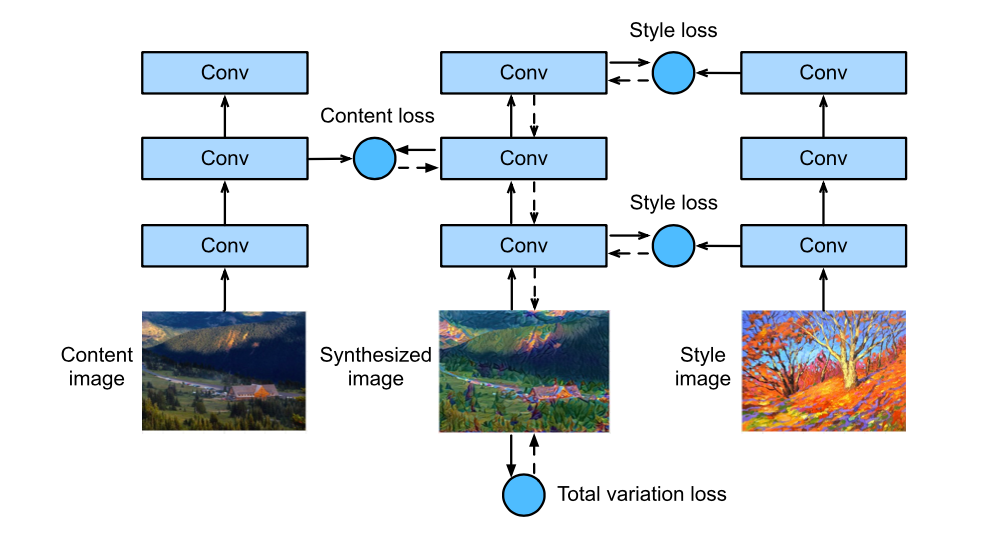

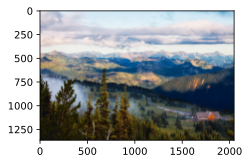

In [20]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import shutil
import requests

d2l.set_figsize()



url = r'https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/rainier.jpg'
response = requests.get(url, stream=True)
with open('content.jpg', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

content_img = d2l.Image.open('/content/content.jpg') 
d2l.plt.imshow(content_img);





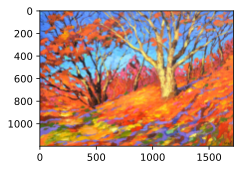

In [21]:
url = r'https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/autumn-oak.jpg'
response = requests.get(url, stream=True)
with open('style.jpg', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

style_img = d2l.Image.open('/content/style.jpg') 
d2l.plt.imshow(style_img);

In [2]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]) 
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
  transforms = torchvision.transforms.Compose(
      [torchvision.transforms.Resize(image_shape), 
       torchvision.transforms.ToTensor(), 
       torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
       ])
  return transforms(img).unsqueeze(0)

def postprocess(img):
  img = img[0].to(rgb_std.device)
  img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1) 
  return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

#Extracting Features

Generally speaking, the closer to the input layer, the easier to extract details of the image, and vice versa, the easier to extract the global information of the image. In order to avoid excessively retaining the details of the content image in the synthesized image, we choose a VGG layer that is closer to the output as the content layer to output the content features of the image.

We also select the output of different VGG layers for extracting local and
global style features. These layers are also called style layers. The VGG network uses 5 convolutional blocks. **In the experiment, we choose the last convolutional layer of the fourth convolutional block as the content layer, and the first convolutional layer of each convolutional block as the style layer.** The indices of these layers can be obtained by printing the pretrained_net instance.

In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True)
pretrained_net

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

**When extracting features using VGG layers, we only need to use all those from the input layer to the content layer or style layer that is closest to the output layer.**

In [8]:
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
def extract_features(X, content_layers, style_layers): 
  contents = []
  styles = []
  for i in range(len(net)):
    X = net[i](X)
    if i in style_layers:
      styles.append(X)
    if i in content_layers:
      contents.append(X) 
  return contents, styles

In [10]:
def get_contents(image_shape, device):
  content_X = preprocess(content_img, image_shape).to(device)
  contents_Y, _ = extract_features(content_X, content_layers, style_layers) 
  return content_X, contents_Y

def get_styles(image_shape, device):
  style_X = preprocess(style_img, image_shape).to(device)
  _, styles_Y = extract_features(style_X, content_layers, style_layers) 
  return style_X, styles_Y

#Loss

The loss function commonly used in style transfer consists of three parts:
 (i) content loss makes the synthesized image and the content image close in content features; 

 (ii) style loss makes the synthesized image and style image close in style features; and 
 
 (iii) total variation loss helps to reduce the noise in the synthesized image. 
 
 Finally, when the model training is over, we output the model parameters of the style transfer to generate the final synthesized image.


##Content Loss

The two inputs of the squared loss function are both outputs of the content layer computed by the extract_features function.

In [11]:
def content_loss(Y_hat, Y):
  # We detach the target content from the tree used to dynamically compute
  # the gradient,this is a stated value, not a variable. Otherwise the loss will throw an error.
  return torch.square(Y_hat - Y.detach()).mean()

##Style Loss

Style loss, similar to content loss, also uses the squared loss function to measure the difference in style between the synthesized image and the style image. To express the style output of any style layer, we first use the extract_features function to compute the style layer output. 

Suppose that the output has 1 example, c channels, height h, and width w, we can transform this output into matrix X with c rows and hw columns. This matrix can be thought of as the concatenation of c vectors x1, . . . , xc, each of which has a length of hw. Here, vector xi represents the style feature of channel i.

In the Gram matrix of these vectors XX.T ∈ Rc×c, element xij in row i and column j is the dot product of vectors xi and xj. **It represents the correlation of the style features of channels i and j.** 

We use this Gram matrix to represent the style output of any style layer. 

**Note that when the value of hw is larger, it likely leads to larger values in the Gram matrix. Note also that the height and width of the Gram matrix are both the number of channels c. To allow style loss not to be affected by these values, the gram function below divides the Gram matrix by the number of its elements, i.e., chw.**


In [23]:
def gram(X):
  num_channels, n = X.shape[1], X.numel() // X.shape[1] 
  X = X.reshape((num_channels, n))
  return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
  return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

##Variation Loss

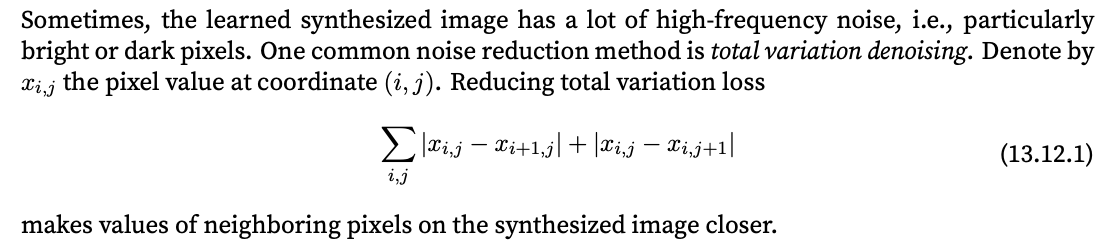

In [12]:
def tv_loss(Y_hat):
  return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

##Total Loss


In [13]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram): 
  contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
  styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
  tv_l = tv_loss(X) * tv_weight
  # Add up all the losses
  l = sum(10 * styles_l + contents_l + [tv_l]) 
  return contents_l, styles_l, tv_l, l

# Synthesized Image

In style transfer, the synthesized image is the only variable that needs to be updated during train- ing. Thus, we can define a simple model, SynthesizedImage, and treat the synthesized image as the model parameters. In this model, forward propagation just returns the model parameters.

In [14]:
class SynthesizedImage(nn.Module):
  def __init__(self, img_shape, **kwargs):
    super(SynthesizedImage, self).__init__(**kwargs) 
    self.weight = nn.Parameter(torch.rand(*img_shape))

  def forward(self): 
    return self.weight

In [15]:
def get_inits(X, device, lr, styles_Y):
  gen_img = SynthesizedImage(X.shape).to(device) 
  gen_img.weight.data.copy_(X.data)
  trainer = torch.optim.Adam(gen_img.parameters(), lr=lr) 
  styles_Y_gram = [gram(Y) for Y in styles_Y]
  return gen_img(), styles_Y_gram, trainer

#Training

Note that we precompute the contents_Y and styles_Y since this does not vary.


In [17]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch): 
  X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8) 
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs], legend=['content', 'style', 'TV'], ncols=2, figsize=(7, 2.5))
  for epoch in range(num_epochs):
    trainer.zero_grad()
    contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers) 
    contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram) 
    l.backward()
    trainer.step() 
    scheduler.step()
    if (epoch + 1) % 10 == 0:
      animator.axes[1].imshow(postprocess(X)) 
      animator.add(epoch + 1, [float(sum(contents_l)),float(sum(styles_l)), float(tv_l)])
  return X

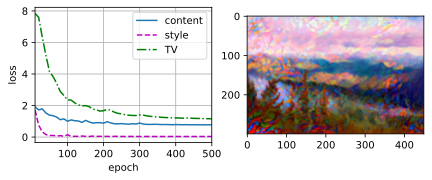

In [24]:
device, image_shape = d2l.try_gpu(), (300, 450) # PIL Image (h, w) 

net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)

output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)